In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
import dask
import gc
import cartopy
import cartopy.crs as ccrs
import bottleneck
import haversine as hs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pygad
from multiprocessing import cpu_count
from os import sched_getaffinity
from collections import Counter
import csv
from collections import defaultdict
import collections
from global_land_mask import globe

In [35]:
n_cores = cpu_count()
print(f'Number of Logical CPU cores: {n_cores}')
n_available_cores = len(sched_getaffinity(0))
print(f'Number of Available CPU cores: {n_available_cores}')

Number of Logical CPU cores: 64
Number of Available CPU cores: 60


In [36]:
#importing dataset
paths = ['./data/netcdf/80m_full_file.nc']
ds = xr.open_mfdataset(paths, parallel=False,concat_dim='time', data_vars='minimal',combine='nested',
                       coords='minimal',compat='override').compute().load()
ds_mean = ds.mean(dim='time')['wind_mag'].transpose().compute().load() #finding averages
ds_distances = xr.open_mfdataset("./data/netcdf/UK_coast_distances.nc").compute()
ds_sum = ds.sum(dim='time')
paths = ['./data/depth_map.nc'] #importing depth dataset
ds_depth = xr.open_mfdataset(paths,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override').compute()

#implement a preloading of summed data for total figures

grdpnt_power = 30*30*6
turbine_rating = 0.9 #MW
n_turbs_grdpnt = grdpnt_power/turbine_rating
loss_factor = 1 #energy lost due to wind turbines in farms


#correlation function definition
def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True)) * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)
def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))
def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)
def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc,
        x,
        y,
        input_core_dims=[[dim], [dim]],
        dask="parallelized",
        output_dtypes=[float])

In [37]:
def open_wind_farm_csv(location):
    """Opens the wind farm csv and outputs a dictionary of locations."""
    columns = defaultdict(list) # each value in each column is appended to a list
    with open(location) as f:
        reader = csv.DictReader(f) # read rows into a dictionary format
        for row in reader: # read a row as {column1: value1, column2: value2,...}
            for (k,v) in row.items(): # go over each column name and value 
                columns[k].append(v) # append the value into the appropriate list
                                     # based on column name k
    coords = dict()
    coords['Latitude'] = np.array(list(map(float, columns['Latitude'][:19])))
    coords['Longitude'] = np.array(list(map(float, columns['Longitude'][:19])))
    return coords

def create_corr_dict():
    #creating correlation dictionary from all specified locations
    corr_dict = dict()
    spec_farm_lats = open_wind_farm_csv('./data/Wind_Farm_Locations.csv')["Latitude"]
    spec_farm_lons = open_wind_farm_csv('./data/Wind_Farm_Locations.csv')["Longitude"]
    spec_farm_lats = (np.round(spec_farm_lats*4, decimals=0)/4)
    spec_farm_lons = (np.round(spec_farm_lons*4, decimals=0)/4)
    n_spec_locs = spec_farm_lats.shape[0] #defining number of specific wind farm locations
    #cycle through wind farm locations to store correlations
    for i in range(n_spec_locs):
        for j in range(i+1):
            array1 = ds['power'].sel(latitude = spec_farm_lats[i], longitude = spec_farm_lons[i]).compute()
            array2 = ds['power'].sel(latitude = spec_farm_lats[j], longitude = spec_farm_lons[j]).compute()
            corr = spearman_correlation(array1, array2, 'time')
            del array1
            del array2
            corr_dict[spec_farm_lats[i],spec_farm_lons[i],spec_farm_lats[j],spec_farm_lons[j]] = corr
            corr_dict[spec_farm_lats[j],spec_farm_lons[j],spec_farm_lats[i],spec_farm_lons[i]] = corr
    
    return corr_dict

corr_dict = create_corr_dict()


def fitness_func_spec(coord_idx, solution_idx):
    """Fitness function to evaluate the validity of set of wind farm locations. Applyies various statistical 
    analyses to the wind speed dataset with repect to the input given. Evaluates the analysis and gives 
    contributing factors to the fitness function that it outputted.
    
    Inputs
    coord_idx: 1D array of latitudes in the first half and longitudes in the second half, each corresponding to 
    their respective pair in the ajdacent half
    Returns
    fitness: value from 0 to 1, 0 is the least 'fit' and 1 it the most 'fit'
    """
    
    coord_idx = coord_idx.astype('int')
    
    #convert indexes to locations
    spec_farm_lats = open_wind_farm_csv('./data/Wind_Farm_Locations.csv')["Latitude"]
    spec_farm_lons = open_wind_farm_csv('./data/Wind_Farm_Locations.csv')["Longitude"]
    spec_farm_lats = (np.round(spec_farm_lats*4, decimals=0)/4)
    spec_farm_lons = (np.round(spec_farm_lons*4, decimals=0)/4)
    lats = spec_farm_lats[coord_idx]
    lons = spec_farm_lons[coord_idx]
    coord_sol = np.hstack((lats,lons))

    
    ##depth##
    #relies on preloaded depth dataset of values z > -60m and location space depths in this range aswell
    lats_init = xr.DataArray(spec_farm_lats[coord_idx], dims='coords')
    lons_init = xr.DataArray(spec_farm_lons[coord_idx], dims='coords') 
    farm_depths = ds_depth.sel(lat = lats_init, lon = lons_init,method="nearest", tolerance=0.1)
    farm_depth_arr = farm_depths.to_array().to_numpy()[0]
    depth_factor = np.mean(1 + farm_depth_arr/(60*3)) #comes from 50% increased cost at 60m below sea level, 
    #maximum of 1/3 penalty factor given due to depth
    
    
    #farm location init.
    num_farms = int(coord_sol.shape[0]/2) #set number of farms
    lats = xr.DataArray(coord_sol[:num_farms], dims='coords')
    lons = xr.DataArray(coord_sol[num_farms:], dims='coords')
    onshore = globe.is_land(lats, lons)
    num_onshore_farms = onshore.sum().item() #number of onshore farm 
    agg_power = ((ds['power']
                     .sel(latitude = lats, longitude = lons)*n_turbs_grdpnt*loss_factor)
                     .sum(dim='coords')).compute()
    
    
    #capacity factor (time averaged power factor)
    total_capacity = 8000 * n_turbs_grdpnt * num_farms #kW
    capacity_factor = agg_power.mean().values/total_capacity
    
    #loss factor for offshore farms
    offshore = np.logical_not(onshore)
    farm_distances = ds_distances.sel(latitude = lats, longitude = lons)
    offshore_dists = farm_distances.where(offshore)
    offshore_dists_far = offshore_dists.where(offshore_dists > 50)
    num_far_offshore_farms = offshore_dists_far.count().to_array().to_numpy()[0]
    offshore_cable_loss = (offshore_dists_far/1000)*0.035 #cable loss
    offshore_loss_avg = 1 - ((offshore_cable_loss.sum().to_array().to_numpy()[0]+0.014*num_far_offshore_farms)
                         /(num_farms)) #avg loss, converts to % and adds conversion loss
    
    #correlation init.
    combinations = int(num_farms*(num_farms-1)/2)
    ranks = xr.DataArray(np.zeros((combinations)))

    #firm capacity init.
    ratios = np.array([0.3,0.4,0.5])
    power_limit = ratios * 8000 * n_turbs_grdpnt * num_farms
    firm_capacity = np.empty((ratios.shape[0]))
    unavailable_prop = np.empty((ratios.shape[0]))
    arr_length = agg_power.shape[0]

    #unavailable init.
    num_yrs = 24 #years
    store = dict()
    store_hours = dict()
    storage_limit = 50 #GWh
    store_above_limit = dict()
    

    for i in range(power_limit.shape[0]):

#         ##unavailable##
#         store[i] = []
#         store_hours[i] = []
#         working_ds = agg_power.copy() - power_limit[i]  
#         working_ds = working_ds.where(working_ds < 0,0).values
#         count = 0 
#         num_hours = 0
#         #sums the groups
#         for j in working_ds:
#             if j.item() == 0:
#                 if count != 0:
#                     store[i].append(count)
#                     store_hours[i].append(num_hours)
#                     count = 0
#                     num_hours = 0
#             else:
#                 count += j.item()
#                 num_hours += 1
#         if count != 0:
#             store[i].append(count)
#             store_hours[i].append(num_hours)
#         store[i] = np.abs(np.array(store[i]))/1e6
#         store_hours[i] = np.sum(np.where(store[i] >= storage_limit,store_hours[i],0))
#         unavailable_prop[i] = store_hours[i]/(8760*24)


        ##firm capacity##
        working_ds = agg_power
        val = working_ds.where(working_ds>=power_limit[i]).count(dim='time').values
        firm_capacity[i] = val/arr_length #proportion of values above the power limit
        
    
    global corr_dict
    ##correlation##           
    count = 0    
    #sums the correlations between each of the 'solution' wind farms
    for i in range(num_farms):
        for j in range(i):        
            ranks[count] = corr_dict[coord_sol[i],coord_sol[num_farms+i],coord_sol[j],coord_sol[num_farms+j]]
            count += 1
    ranks = ranks.to_numpy()
    rank = (np.average(ranks)+1)/2 #0 to 1
    
    
    
    #better = larger
    fitness = ((1-rank) * np.average(firm_capacity) * 1.0**num_onshore_farms * offshore_loss_avg 
               * capacity_factor * depth_factor) # * (1 - np.average(unavailable_prop)))
    
    
    #print('Unavailable prop:',unavailable_prop[:]) #unavailable prop discarded - same measure as firm capacity
#     print('Firm capacity:',firm_capacity[:])
#     print('Avg. correlation:',rank)
#     print('Offshore loss:',offshore_loss_avg)
#     print('Capacity factor:',capacity_factor)
#     print('Depth factor:',depth_factor)
#     print('Fitness:',fitness)
    
    return fitness

In [38]:
fitness_function = fitness_func_spec

num_generations = 100
num_parents_mating = 2

sol_per_pop = 50 #num different groups that can be chosen (# chromosomes)
num_genes = 3 #num of farms per group (# genes per chromosome)

#create gene_space
gene_space=np.arange(0,open_wind_farm_csv('./data/Wind_Farm_Locations.csv')["Latitude"].shape[0],dtype='int')

parent_selection_type = "rank"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "adaptive"
mutation_percent_genes = [30,10]

def callback_gen(ga_instance):
    print("Generation : ", ga_instance.generations_completed)
    print("Fitness of the best solution :", ga_instance.best_solution()[1])

last_fitness = 0
start_step = time.time()
def on_generation(ga_instance):
    global last_fitness
    global start_step
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness))
    end = time.time()
    print('Time taken:',np.round(end-start_step,decimals=3),'secs \n')
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]
    start_step = time.time()

Generation = 1
Fitness    = 0.08979088618552272
Change     = 0.08979088618552272
Time taken: 77.784 secs 

Generation = 2
Fitness    = 0.09233023517283885
Change     = 0.0025393489873161285
Time taken: 12.554 secs 

Generation = 3
Fitness    = 0.09668319868618352
Change     = 0.004352963513344674
Time taken: 13.152 secs 

Generation = 4
Fitness    = 0.09668319868618352
Change     = 0.0
Time taken: 13.831 secs 

Generation = 5
Fitness    = 0.09668319868618352
Change     = 0.0
Time taken: 15.924 secs 

Generation = 6
Fitness    = 0.09668319868618352
Change     = 0.0
Time taken: 13.369 secs 

Generation = 7
Fitness    = 0.09668319868618352
Change     = 0.0
Time taken: 15.925 secs 

Generation = 8
Fitness    = 0.09668319868618352
Change     = 0.0
Time taken: 14.474 secs 

Generation = 9
Fitness    = 0.09679372972765324
Change     = 0.0001105310414697136
Time taken: 13.471 secs 

Generation = 10
Fitness    = 0.09679372972765324
Change     = 0.0
Time taken: 15.588 secs 

Generation = 11
Fitn

Generation = 88
Fitness    = 0.10195572996112415
Change     = 0.0
Time taken: 15.151 secs 

Generation = 89
Fitness    = 0.10195572996112415
Change     = 0.0
Time taken: 12.85 secs 

Generation = 90
Fitness    = 0.10195572996112415
Change     = 0.0
Time taken: 15.306 secs 

Generation = 91
Fitness    = 0.10195572996112415
Change     = 0.0
Time taken: 14.393 secs 

Generation = 92
Fitness    = 0.10195572996112415
Change     = 0.0
Time taken: 12.588 secs 

Generation = 93
Fitness    = 0.10195572996112415
Change     = 0.0
Time taken: 13.029 secs 

Generation = 94
Fitness    = 0.10195572996112415
Change     = 0.0
Time taken: 13.245 secs 

Generation = 95
Fitness    = 0.10195572996112415
Change     = 0.0
Time taken: 12.384 secs 

Generation = 96
Fitness    = 0.10195572996112415
Change     = 0.0
Time taken: 13.58 secs 

Generation = 97
Fitness    = 0.10195572996112415
Change     = 0.0
Time taken: 12.308 secs 

Generation = 98
Fitness    = 0.10195572996112415
Change     = 0.0
Time taken: 12.3

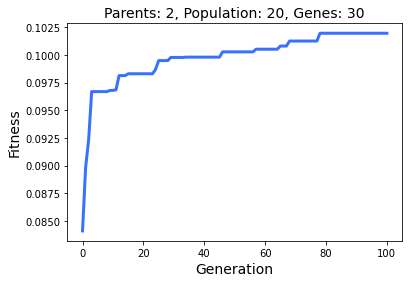

/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/pygad/pygad.py:828: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Generation = 1
Fitness    = 0.08630177359942019
Change     = -0.015653956361703955
Time taken: 36.09 secs 

Generation = 2
Fitness    = 0.09014956755432033
Change     = 0.0038477939549001333
Time taken: 18.299 secs 

Generation = 3
Fitness    = 0.0901512922928009
Change     = 1.7247384805768595e-06
Time taken: 17.234 secs 

Generation = 4
Fitness    = 0.09060860431141728
Change     = 0.0004573120186163737
Time taken: 19.116 secs 

Generation = 5
Fitness    = 0.09276903125368192
Change     = 0.0021604269422646483
Time taken: 16.856 secs 

Generation = 6
Fitness    = 0.09320146120852466
Change     = 0.0004324299548427307
Time taken: 18.196 secs 

Generation = 7
Fitness    = 0.09514007070680892
Change     = 0.0019386094982842689
Time taken: 17.074 secs 

Generation = 8
Fitness    = 0.09630302934422653
Change     = 0.0011629586374176104
Time taken: 17.267 secs 

Generation = 9
Fitness    = 0.09630302934422653
Change     = 0.0
Time taken: 16.476 secs 

Generation = 10
Fitness    = 0.0963030

Generation = 87
Fitness    = 0.10006835738374215
Change     = 0.0
Time taken: 17.939 secs 

Generation = 88
Fitness    = 0.10006835738374215
Change     = 0.0
Time taken: 16.86 secs 

Generation = 89
Fitness    = 0.10006835738374215
Change     = 0.0
Time taken: 17.237 secs 

Generation = 90
Fitness    = 0.10006835738374215
Change     = 0.0
Time taken: 17.243 secs 

Generation = 91
Fitness    = 0.10006835738374215
Change     = 0.0
Time taken: 16.425 secs 

Generation = 92
Fitness    = 0.10006835738374215
Change     = 0.0
Time taken: 16.713 secs 

Generation = 93
Fitness    = 0.10006835738374215
Change     = 0.0
Time taken: 18.897 secs 

Generation = 94
Fitness    = 0.10006835738374215
Change     = 0.0
Time taken: 16.96 secs 

Generation = 95
Fitness    = 0.10006835738374215
Change     = 0.0
Time taken: 16.864 secs 

Generation = 96
Fitness    = 0.10006835738374215
Change     = 0.0
Time taken: 16.907 secs 

Generation = 97
Fitness    = 0.10006835738374215
Change     = 0.0
Time taken: 17.9

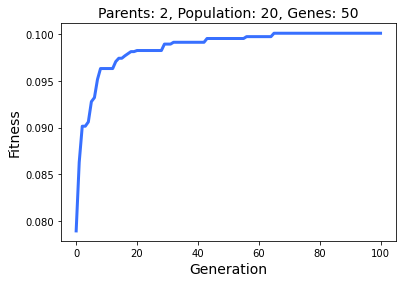

/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/pygad/pygad.py:828: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Generation = 1
Fitness    = 0.091397202740732
Change     = -0.008671154643010145
Time taken: 49.51 secs 

Generation = 2
Fitness    = 0.09237486915862037
Change     = 0.0009776664178883648
Time taken: 21.75 secs 

Generation = 3
Fitness    = 0.09601764992570669
Change     = 0.0036427807670863233
Time taken: 21.665 secs 

Generation = 4
Fitness    = 0.09640401203710752
Change     = 0.0003863621114008342
Time taken: 23.768 secs 

Generation = 5
Fitness    = 0.09680822134550468
Change     = 0.00040420930839715763
Time taken: 21.424 secs 

Generation = 6
Fitness    = 0.09827022760352963
Change     = 0.0014620062580249504
Time taken: 21.953 secs 

Generation = 7
Fitness    = 0.09869788448369061
Change     = 0.00042765688016098424
Time taken: 24.967 secs 

Generation = 8
Fitness    = 0.09869788448369061
Change     = 0.0
Time taken: 21.173 secs 

Generation = 9
Fitness    = 0.09920042301514957
Change     = 0.000502538531458957
Time taken: 22.046 secs 

Generation = 10
Fitness    = 0.099200423

Generation = 92
Fitness    = 0.1015270993510136
Change     = 0.0
Time taken: 23.856 secs 

Generation = 93
Fitness    = 0.1015270993510136
Change     = 0.0
Time taken: 22.567 secs 

Generation = 94
Fitness    = 0.10174580265526512
Change     = 0.00021870330425151352
Time taken: 23.024 secs 

Generation = 95
Fitness    = 0.10174580265526512
Change     = 0.0
Time taken: 24.227 secs 

Generation = 96
Fitness    = 0.10174580265526512
Change     = 0.0
Time taken: 25.385 secs 

Generation = 97
Fitness    = 0.10174580265526512
Change     = 0.0
Time taken: 25.024 secs 

Generation = 98
Fitness    = 0.10174580265526512
Change     = 0.0
Time taken: 24.939 secs 

Generation = 99
Fitness    = 0.10174580265526512
Change     = 0.0
Time taken: 23.849 secs 

Generation = 100
Fitness    = 0.10174580265526512
Change     = 0.0
Time taken: 22.567 secs 

Time taken: 2317.865 Step: 66


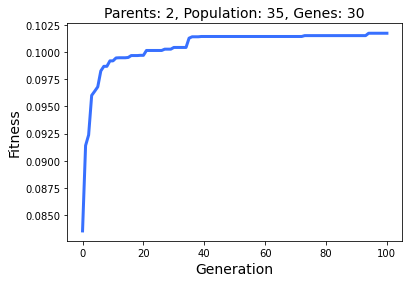

/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/pygad/pygad.py:828: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Generation = 1
Fitness    = 0.08140364336834606
Change     = -0.020342159286919057
Time taken: 64.593 secs 

Generation = 2
Fitness    = 0.08345226230799688
Change     = 0.0020486189396508175
Time taken: 33.445 secs 

Generation = 3
Fitness    = 0.08742461497657862
Change     = 0.003972352668581744
Time taken: 29.877 secs 

Generation = 4
Fitness    = 0.09096787665043417
Change     = 0.0035432616738555467
Time taken: 28.885 secs 

Generation = 5
Fitness    = 0.09126646713600929
Change     = 0.00029859048557512313
Time taken: 33.086 secs 

Generation = 6
Fitness    = 0.09306945483567063
Change     = 0.0018029876996613348
Time taken: 35.728 secs 

Generation = 7
Fitness    = 0.09315441043371252
Change     = 8.495559804189146e-05
Time taken: 34.988 secs 

Generation = 8
Fitness    = 0.09315441043371252
Change     = 0.0
Time taken: 32.273 secs 

Generation = 9
Fitness    = 0.09472740685383507
Change     = 0.001572996420122555
Time taken: 29.697 secs 

Generation = 10
Fitness    = 0.0949182

Generation = 87
Fitness    = 0.09970930296185353
Change     = 0.0
Time taken: 32.625 secs 

Generation = 88
Fitness    = 0.09970930296185353
Change     = 0.0
Time taken: 32.906 secs 

Generation = 89
Fitness    = 0.09970930296185353
Change     = 0.0
Time taken: 29.551 secs 

Generation = 90
Fitness    = 0.09970930296185353
Change     = 0.0
Time taken: 32.691 secs 

Generation = 91
Fitness    = 0.09970930296185353
Change     = 0.0
Time taken: 31.979 secs 

Generation = 92
Fitness    = 0.09970930296185353
Change     = 0.0
Time taken: 31.362 secs 

Generation = 93
Fitness    = 0.09970930296185353
Change     = 0.0
Time taken: 31.267 secs 

Generation = 94
Fitness    = 0.09970930296185353
Change     = 0.0
Time taken: 33.777 secs 

Generation = 95
Fitness    = 0.09970930296185353
Change     = 0.0
Time taken: 34.151 secs 

Generation = 96
Fitness    = 0.09970930296185353
Change     = 0.0
Time taken: 29.79 secs 

Generation = 97
Fitness    = 0.09970930296185353
Change     = 0.0
Time taken: 30.

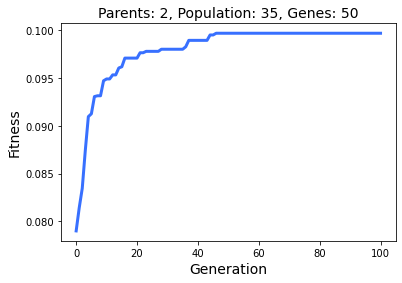

/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/pygad/pygad.py:828: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Generation = 1
Fitness    = 0.08815358029634579
Change     = -0.011555722665507737
Time taken: 76.043 secs 

Generation = 2
Fitness    = 0.08997423639535763
Change     = 0.0018206560990118442
Time taken: 33.479 secs 

Generation = 3
Fitness    = 0.09339429444903259
Change     = 0.003420058053674957
Time taken: 32.107 secs 

Generation = 4
Fitness    = 0.09339429444903259
Change     = 0.0
Time taken: 32.155 secs 

Generation = 5
Fitness    = 0.09444587810189325
Change     = 0.0010515836528606631
Time taken: 32.391 secs 

Generation = 6
Fitness    = 0.09565149421281245
Change     = 0.001205616110919197
Time taken: 29.744 secs 

Generation = 7
Fitness    = 0.09592101624391501
Change     = 0.00026952203110255923
Time taken: 29.868 secs 

Generation = 8
Fitness    = 0.09645409364910465
Change     = 0.0005330774051896386
Time taken: 31.446 secs 

Generation = 9
Fitness    = 0.09741147593619187
Change     = 0.0009573822870872217
Time taken: 32.603 secs 

Generation = 10
Fitness    = 0.0988072

Generation = 91
Fitness    = 0.10143051412356531
Change     = 0.0
Time taken: 30.047 secs 

Generation = 92
Fitness    = 0.10143051412356531
Change     = 0.0
Time taken: 28.743 secs 

Generation = 93
Fitness    = 0.10143051412356531
Change     = 0.0
Time taken: 29.002 secs 

Generation = 94
Fitness    = 0.10143051412356531
Change     = 0.0
Time taken: 29.352 secs 

Generation = 95
Fitness    = 0.10143051412356531
Change     = 0.0
Time taken: 30.166 secs 

Generation = 96
Fitness    = 0.10143051412356532
Change     = 1.3877787807814457e-17
Time taken: 30.759 secs 

Generation = 97
Fitness    = 0.10143051412356532
Change     = 0.0
Time taken: 30.396 secs 

Generation = 98
Fitness    = 0.10143051412356532
Change     = 0.0
Time taken: 30.359 secs 

Generation = 99
Fitness    = 0.10143051412356532
Change     = 0.0
Time taken: 32.335 secs 

Generation = 100
Fitness    = 0.10143051412356532
Change     = 0.0
Time taken: 31.737 secs 

Time taken: 3082.626 Step: 66


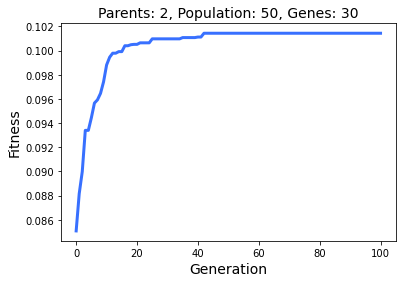

/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/pygad/pygad.py:828: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Generation = 1
Fitness    = 0.08596828690754917
Change     = -0.015462227216016158
Time taken: 84.702 secs 

Generation = 2
Fitness    = 0.08693882551042798
Change     = 0.0009705386028788093
Time taken: 41.397 secs 

Generation = 3
Fitness    = 0.09013236274243644
Change     = 0.0031935372320084643
Time taken: 41.821 secs 

Generation = 4
Fitness    = 0.09097811512833773
Change     = 0.0008457523859012883
Time taken: 42.043 secs 

Generation = 5
Fitness    = 0.09200364111050259
Change     = 0.0010255259821648627
Time taken: 43.554 secs 

Generation = 6
Fitness    = 0.09271298884099148
Change     = 0.0007093477304888907
Time taken: 40.896 secs 

Generation = 7
Fitness    = 0.09336537088437363
Change     = 0.000652382043382152
Time taken: 43.605 secs 

Generation = 8
Fitness    = 0.09336537088437363
Change     = 0.0
Time taken: 40.811 secs 

Generation = 9
Fitness    = 0.09361784166941038
Change     = 0.0002524707850367486
Time taken: 41.79 secs 

Generation = 10
Fitness    = 0.09416158

Generation = 86
Fitness    = 0.0997598991464452
Change     = 0.0
Time taken: 40.504 secs 

Generation = 87
Fitness    = 0.0997598991464452
Change     = 0.0
Time taken: 41.204 secs 

Generation = 88
Fitness    = 0.0997598991464452
Change     = 0.0
Time taken: 41.352 secs 

Generation = 89
Fitness    = 0.0997598991464452
Change     = 0.0
Time taken: 39.858 secs 

Generation = 90
Fitness    = 0.0997598991464452
Change     = 0.0
Time taken: 40.779 secs 

Generation = 91
Fitness    = 0.0997598991464452
Change     = 0.0
Time taken: 41.958 secs 

Generation = 92
Fitness    = 0.0997598991464452
Change     = 0.0
Time taken: 43.237 secs 

Generation = 93
Fitness    = 0.0997598991464452
Change     = 0.0
Time taken: 40.275 secs 

Generation = 94
Fitness    = 0.0997598991464452
Change     = 0.0
Time taken: 42.836 secs 

Generation = 95
Fitness    = 0.0997598991464452
Change     = 0.0
Time taken: 44.509 secs 

Generation = 96
Fitness    = 0.0997598991464452
Change     = 0.0
Time taken: 40.822 secs 


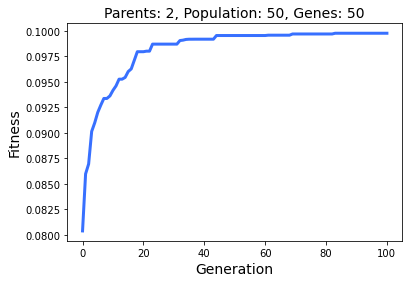

/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/pygad/pygad.py:828: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Generation = 1
Fitness    = 0.08066483127556516
Change     = -0.019095067870880042
Time taken: 46.361 secs 

Generation = 2
Fitness    = 0.08833763122553068
Change     = 0.007672799949965517
Time taken: 14.679 secs 

Generation = 3
Fitness    = 0.09322406302431768
Change     = 0.004886431798787005
Time taken: 12.913 secs 

Generation = 4
Fitness    = 0.09333989039228884
Change     = 0.00011582736797115245
Time taken: 12.561 secs 

Generation = 5
Fitness    = 0.09372966138885637
Change     = 0.00038977099656753444
Time taken: 11.98 secs 

Generation = 6
Fitness    = 0.09372966138885637
Change     = 0.0
Time taken: 12.927 secs 

Generation = 7
Fitness    = 0.09372966138885637
Change     = 0.0
Time taken: 14.835 secs 

Generation = 8
Fitness    = 0.0953143276307434
Change     = 0.0015846662418870366
Time taken: 13.222 secs 

Generation = 9
Fitness    = 0.0953143276307434
Change     = 0.0
Time taken: 13.074 secs 

Generation = 10
Fitness    = 0.0953143276307434
Change     = 0.0
Time taken:

Generation = 86
Fitness    = 0.1005965919890794
Change     = 0.0
Time taken: 13.584 secs 

Generation = 87
Fitness    = 0.1005965919890794
Change     = 0.0
Time taken: 13.134 secs 

Generation = 88
Fitness    = 0.1005965919890794
Change     = 0.0
Time taken: 13.35 secs 

Generation = 89
Fitness    = 0.1005965919890794
Change     = 0.0
Time taken: 12.702 secs 

Generation = 90
Fitness    = 0.1005965919890794
Change     = 0.0
Time taken: 12.264 secs 

Generation = 91
Fitness    = 0.1005965919890794
Change     = 0.0
Time taken: 12.453 secs 

Generation = 92
Fitness    = 0.1005965919890794
Change     = 0.0
Time taken: 13.025 secs 

Generation = 93
Fitness    = 0.1005965919890794
Change     = 0.0
Time taken: 13.781 secs 

Generation = 94
Fitness    = 0.1005965919890794
Change     = 0.0
Time taken: 13.142 secs 

Generation = 95
Fitness    = 0.1005965919890794
Change     = 0.0
Time taken: 13.065 secs 

Generation = 96
Fitness    = 0.1005965919890794
Change     = 0.0
Time taken: 13.58 secs 

G

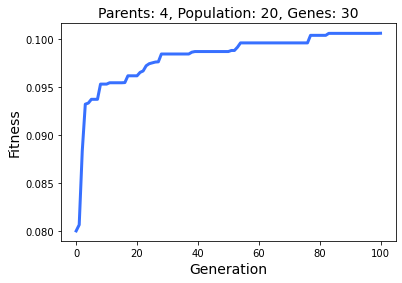

/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/pygad/pygad.py:828: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Generation = 1
Fitness    = 0.07894147207539656
Change     = -0.021667959697461006
Time taken: 37.466 secs 

Generation = 2
Fitness    = 0.08106092967995845
Change     = 0.002119457604561892
Time taken: 17.54 secs 

Generation = 3
Fitness    = 0.08141241899907879
Change     = 0.00035148931912033776
Time taken: 19.124 secs 

Generation = 4
Fitness    = 0.08463534054327276
Change     = 0.0032229215441939713
Time taken: 17.256 secs 

Generation = 5
Fitness    = 0.0863577031509725
Change     = 0.0017223626076997428
Time taken: 18.095 secs 

Generation = 6
Fitness    = 0.08638783482458533
Change     = 3.0131673612820986e-05
Time taken: 18.144 secs 

Generation = 7
Fitness    = 0.08836055189950551
Change     = 0.00197271707492018
Time taken: 18.419 secs 

Generation = 8
Fitness    = 0.0906226396612536
Change     = 0.002262087761748091
Time taken: 18.359 secs 

Generation = 9
Fitness    = 0.0906226396612536
Change     = 0.0
Time taken: 19.074 secs 

Generation = 10
Fitness    = 0.091636227871

Generation = 87
Fitness    = 0.09779217366088763
Change     = 0.0
Time taken: 17.206 secs 

Generation = 88
Fitness    = 0.09779217366088763
Change     = 0.0
Time taken: 18.967 secs 

Generation = 89
Fitness    = 0.09779217366088763
Change     = 0.0
Time taken: 17.597 secs 

Generation = 90
Fitness    = 0.09779217366088763
Change     = 0.0
Time taken: 17.83 secs 

Generation = 91
Fitness    = 0.09779217366088763
Change     = 0.0
Time taken: 17.783 secs 

Generation = 92
Fitness    = 0.09779217366088763
Change     = 0.0
Time taken: 17.184 secs 

Generation = 93
Fitness    = 0.09779217366088763
Change     = 0.0
Time taken: 17.357 secs 

Generation = 94
Fitness    = 0.09779217366088763
Change     = 0.0
Time taken: 17.128 secs 

Generation = 95
Fitness    = 0.09779217366088763
Change     = 0.0
Time taken: 17.452 secs 

Generation = 96
Fitness    = 0.09779217366088763
Change     = 0.0
Time taken: 16.786 secs 

Generation = 97
Fitness    = 0.09779217366088763
Change     = 0.0
Time taken: 18.

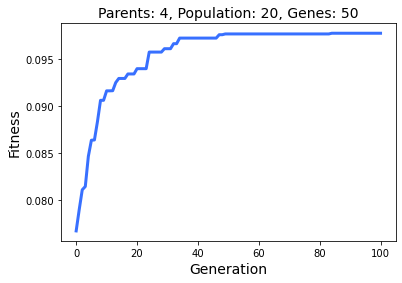

/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/pygad/pygad.py:828: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Generation = 1
Fitness    = 0.08645015873639589
Change     = -0.011342014924491745
Time taken: 49.773 secs 

Generation = 2
Fitness    = 0.08766259825863353
Change     = 0.0012124395222376377
Time taken: 21.714 secs 

Generation = 3
Fitness    = 0.08895280152969558
Change     = 0.0012902032710620515
Time taken: 22.782 secs 

Generation = 4
Fitness    = 0.09364510464562108
Change     = 0.0046923031159255
Time taken: 21.799 secs 

Generation = 5
Fitness    = 0.09534001477416038
Change     = 0.0016949101285392981
Time taken: 21.293 secs 

Generation = 6
Fitness    = 0.09534001477416038
Change     = 0.0
Time taken: 22.174 secs 

Generation = 7
Fitness    = 0.0967620806359168
Change     = 0.0014220658617564302
Time taken: 22.382 secs 

Generation = 8
Fitness    = 0.09740733642263422
Change     = 0.0006452557867174108
Time taken: 22.263 secs 

Generation = 9
Fitness    = 0.09779770781002094
Change     = 0.0003903713873867204
Time taken: 22.557 secs 

Generation = 10
Fitness    = 0.0980080138

Generation = 86
Fitness    = 0.10054111024761728
Change     = 0.00018232057039174743
Time taken: 22.161 secs 

Generation = 87
Fitness    = 0.10054111024761728
Change     = 0.0
Time taken: 21.34 secs 

Generation = 88
Fitness    = 0.10054111024761728
Change     = 0.0
Time taken: 21.91 secs 

Generation = 89
Fitness    = 0.10060475546060746
Change     = 6.364521299018211e-05
Time taken: 21.038 secs 

Generation = 90
Fitness    = 0.10060475546060746
Change     = 0.0
Time taken: 22.179 secs 

Generation = 91
Fitness    = 0.10060475546060746
Change     = 0.0
Time taken: 21.474 secs 

Generation = 92
Fitness    = 0.10060475546060746
Change     = 0.0
Time taken: 21.554 secs 

Generation = 93
Fitness    = 0.10086815725313751
Change     = 0.0002634017925300519
Time taken: 21.797 secs 

Generation = 94
Fitness    = 0.10088888198850039
Change     = 2.072473536288144e-05
Time taken: 21.101 secs 

Generation = 95
Fitness    = 0.10088888198850039
Change     = 0.0
Time taken: 22.087 secs 

Generatio

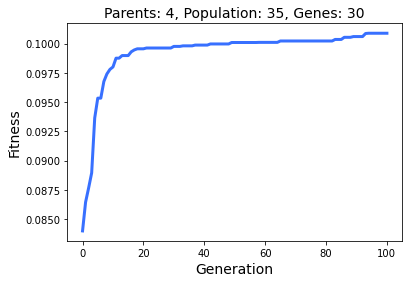

/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/pygad/pygad.py:828: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Generation = 1
Fitness    = 0.08240526590274606
Change     = -0.01848361608575433
Time taken: 61.176 secs 

Generation = 2
Fitness    = 0.08377875722163168
Change     = 0.0013734913188856168
Time taken: 29.08 secs 

Generation = 3
Fitness    = 0.0846024758573223
Change     = 0.0008237186356906262
Time taken: 28.531 secs 

Generation = 4
Fitness    = 0.08768647015384347
Change     = 0.0030839942965211614
Time taken: 30.826 secs 

Generation = 5
Fitness    = 0.09045787743747705
Change     = 0.0027714072836335785
Time taken: 30.732 secs 

Generation = 6
Fitness    = 0.09045787743747705
Change     = 0.0
Time taken: 30.109 secs 

Generation = 7
Fitness    = 0.09073456279311091
Change     = 0.0002766853556338683
Time taken: 29.186 secs 

Generation = 8
Fitness    = 0.0923147520406139
Change     = 0.001580189247502986
Time taken: 28.654 secs 

Generation = 9
Fitness    = 0.09316595186288087
Change     = 0.0008511998222669737
Time taken: 28.825 secs 

Generation = 10
Fitness    = 0.09343188265

Generation = 87
Fitness    = 0.09872380917285191
Change     = 0.0
Time taken: 30.784 secs 

Generation = 88
Fitness    = 0.09872380917285191
Change     = 0.0
Time taken: 30.327 secs 

Generation = 89
Fitness    = 0.09872380917285191
Change     = 0.0
Time taken: 29.604 secs 

Generation = 90
Fitness    = 0.09872380917285191
Change     = 0.0
Time taken: 29.315 secs 

Generation = 91
Fitness    = 0.09872380917285191
Change     = 0.0
Time taken: 30.942 secs 

Generation = 92
Fitness    = 0.09872380917285191
Change     = 0.0
Time taken: 29.888 secs 

Generation = 93
Fitness    = 0.09872380917285191
Change     = 0.0
Time taken: 29.288 secs 

Generation = 94
Fitness    = 0.09872380917285191
Change     = 0.0
Time taken: 29.412 secs 

Generation = 95
Fitness    = 0.09872380917285191
Change     = 0.0
Time taken: 28.495 secs 

Generation = 96
Fitness    = 0.09872380917285191
Change     = 0.0
Time taken: 29.245 secs 

Generation = 97
Fitness    = 0.09872380917285191
Change     = 0.0
Time taken: 31

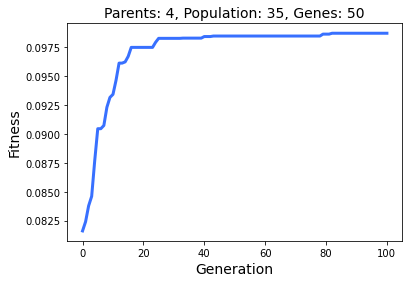

/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/pygad/pygad.py:828: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Generation = 1
Fitness    = 0.08627804659526915
Change     = -0.012445762577582759
Time taken: 66.19 secs 

Generation = 2
Fitness    = 0.09155640056948783
Change     = 0.0052783539742186775
Time taken: 29.841 secs 

Generation = 3
Fitness    = 0.0930252893214044
Change     = 0.0014688887519165722
Time taken: 29.6 secs 

Generation = 4
Fitness    = 0.09428489812255382
Change     = 0.00125960880114942
Time taken: 29.738 secs 

Generation = 5
Fitness    = 0.09499103248387496
Change     = 0.0007061343613211368
Time taken: 29.849 secs 

Generation = 6
Fitness    = 0.09499103248387496
Change     = 0.0
Time taken: 31.669 secs 

Generation = 7
Fitness    = 0.09605840837522041
Change     = 0.0010673758913454512
Time taken: 33.414 secs 

Generation = 8
Fitness    = 0.09658860971796106
Change     = 0.0005302013427406493
Time taken: 32.273 secs 

Generation = 9
Fitness    = 0.09743676901559228
Change     = 0.0008481592976312263
Time taken: 31.454 secs 

Generation = 10
Fitness    = 0.099601129932

Generation = 87
Fitness    = 0.10164439791997151
Change     = 0.0
Time taken: 29.729 secs 

Generation = 88
Fitness    = 0.10164439791997151
Change     = 0.0
Time taken: 31.94 secs 

Generation = 89
Fitness    = 0.10164439791997151
Change     = 0.0
Time taken: 33.791 secs 

Generation = 90
Fitness    = 0.10164439791997151
Change     = 0.0
Time taken: 32.874 secs 

Generation = 91
Fitness    = 0.10164439791997151
Change     = 0.0
Time taken: 32.132 secs 

Generation = 92
Fitness    = 0.10164439791997151
Change     = 0.0
Time taken: 33.855 secs 

Generation = 93
Fitness    = 0.10164439791997151
Change     = 0.0
Time taken: 32.182 secs 

Generation = 94
Fitness    = 0.10164439791997151
Change     = 0.0
Time taken: 29.731 secs 

Generation = 95
Fitness    = 0.10164439791997151
Change     = 0.0
Time taken: 31.564 secs 

Generation = 96
Fitness    = 0.10164439791997151
Change     = 0.0
Time taken: 28.622 secs 

Generation = 97
Fitness    = 0.10164439791997151
Change     = 0.0
Time taken: 29.

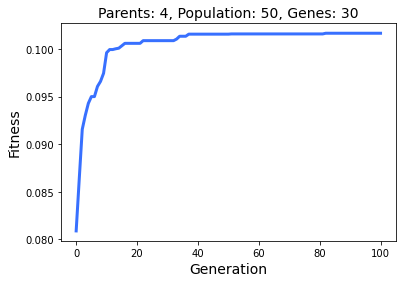

/home/xzcaphbe/.conda/envs/env3.8_optimise/lib/python3.8/site-packages/pygad/pygad.py:828: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


Generation = 1
Fitness    = 0.08114158817131574
Change     = -0.020502809748655773
Time taken: 86.017 secs 

Generation = 2
Fitness    = 0.0832738657829987
Change     = 0.002132277611682956
Time taken: 41.995 secs 

Generation = 3
Fitness    = 0.08561102924434323
Change     = 0.0023371634613445352
Time taken: 40.089 secs 

Generation = 4
Fitness    = 0.0894246797976068
Change     = 0.0038136505532635617
Time taken: 41.497 secs 

Generation = 5
Fitness    = 0.09147704693033637
Change     = 0.0020523671327295767
Time taken: 40.184 secs 

Generation = 6
Fitness    = 0.09231546782201452
Change     = 0.0008384208916781544
Time taken: 42.958 secs 

Generation = 7
Fitness    = 0.09283053817792837
Change     = 0.0005150703559138464
Time taken: 40.515 secs 

Generation = 8
Fitness    = 0.09283053817792837
Change     = 0.0
Time taken: 42.442 secs 

Generation = 9
Fitness    = 0.09354336699607321
Change     = 0.0007128288181448422
Time taken: 41.931 secs 

Generation = 10
Fitness    = 0.095400026

Generation = 87
Fitness    = 0.0998100027975299
Change     = 0.0
Time taken: 42.084 secs 

Generation = 88
Fitness    = 0.0998100027975299
Change     = 0.0
Time taken: 41.467 secs 

Generation = 89
Fitness    = 0.0998100027975299
Change     = 0.0
Time taken: 40.093 secs 

Generation = 90
Fitness    = 0.0998100027975299
Change     = 0.0
Time taken: 40.424 secs 

Generation = 91
Fitness    = 0.0998100027975299
Change     = 0.0
Time taken: 41.0 secs 

Generation = 92
Fitness    = 0.0998100027975299
Change     = 0.0
Time taken: 41.536 secs 

Generation = 93
Fitness    = 0.0998100027975299
Change     = 0.0
Time taken: 40.163 secs 

Generation = 94
Fitness    = 0.0998100027975299
Change     = 0.0
Time taken: 40.472 secs 

Generation = 95
Fitness    = 0.0998100027975299
Change     = 0.0
Time taken: 40.115 secs 

Generation = 96
Fitness    = 0.0998100027975299
Change     = 0.0
Time taken: 43.956 secs 

Generation = 97
Fitness    = 0.0998100027975299
Change     = 0.0
Time taken: 41.241 secs 

G

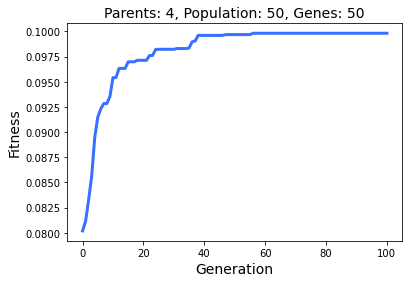

In [41]:
num_parents_mating = [2,4]

sol_per_pop = [20,35,50] #num different groups that can be chosen (# chromosomes)
num_genes = [30,50] #num of farms per group (# genes per chromosome)

for i in range(len(num_parents_mating)):
    for j in range(len(sol_per_pop)):
        for k in range(len(num_genes)):    
            ga_instance = pygad.GA(num_generations=num_generations,
                               gene_space = gene_space,
                               num_parents_mating=num_parents_mating[i],
                               fitness_func=fitness_function,
                               sol_per_pop=sol_per_pop[j],
                               num_genes=num_genes[k],
                               parent_selection_type=parent_selection_type,
                               keep_parents=keep_parents,
                               crossover_type=crossover_type,
                               mutation_type=mutation_type,
                               mutation_percent_genes=mutation_percent_genes,
                               on_generation=on_generation,
                               parallel_processing=["process",sol_per_pop[j]],
                               save_solutions = True)
    
            start = time.time()
            ga_instance.run()
            end = time.time()
            print('Time taken:',np.round(end-start,decimals=3), 'Step:',66+i)
    
            solution, solution_fitness, solution_idx = ga_instance.best_solution()
            x = ga_instance.plot_fitness(title=(f'Parents: {num_parents_mating[i]}, Population: {sol_per_pop[j]}, Genes: {num_genes[k]}')
                                         ,save_dir=f'./figures/fitness_graphs/plot{i}{j}{k}.pdf')